<a href="https://colab.research.google.com/github/rafaela00castro/pytorch-hands-on/blob/master/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on 




<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/pytorch.png" width=250>

> ### Machine Learning course / PPCIC @ CEFET-RJ 
> Rafaela Castro  (<rafaela.nascimento@eic.cefet-rj.br>) - April/2019

---


## Images classification with Convolutional Neural Networks (CNN)

We will train a CNN to classify images from MNIST dataset, which is a hand-written digit dataset. The images are of size 1x32x32, i.e. 1-channel grey levels images.

First of all, let's check the configuration of Colab's processor.

In [1]:
!lscpu # cpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2200.000
BogoMIPS:            4400.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [2]:
!nvidia-smi # gpu

Thu Apr 18 14:51:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Install Pytorch

Since January/19, Colab supports PyTorch natively. So, you do not need to run the code below.

`!pip install torch torchvision`

### Import libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

### Device configuration

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Define seed

In [0]:
seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic=True

### Load and normalize MNIST

The output of torchvision datasets are [PIL image](https://en.wikipedia.org/wiki/Python_Imaging_Library) images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                              ])

In [7]:
batch_size = 20
n_workers = 2

train_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform=transform)

print('Size train dataset: ', len(train_data))

train_loader = DataLoader(train_data, batch_size=batch_size,
                          shuffle=True, num_workers=n_workers)


test_data = datasets.MNIST(root='./data', train=False,
                           download=True, transform=transform)

print('Size test dataset: ', len(test_data))

test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False, num_workers=n_workers)

Size train dataset:  60000
Size test dataset:  10000


### Visualize some images

In [0]:
def imshow(img_tensor):
  """
  function to show an image
  """
  img_tensor = img_tensor / 2 + 0.5     # unnormalize
  img_numpy = img_tensor.numpy()        # from tensor to numpy
  plt.imshow(np.transpose(img_numpy, (1, 2, 0)))
  plt.show()

Get one batch of training images.

In [9]:
data_iter = iter(train_loader)
images, labels = data_iter.next()
print('(batch size, channels, height, width) ', images.shape)

(batch size, channels, height, width)  torch.Size([20, 1, 28, 28])


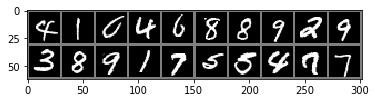

In [10]:
imshow(make_grid(images, nrow=10))

### Define the network architecture

<img src="https://raw.githubusercontent.com/floydhub/mnist/master/images/mnist_convet.png">

How to calculate output size?

$outup\_size = \dfrac{(input\_size - kernel\_size +2 * padding\_size)}{stride\_size} + 1$

In [0]:
class ConvNet(nn.Module):
  
  def __init__(self):
    super(ConvNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=5, stride=2))

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.fc1 = nn.Linear(20*4*4, 50)
    self.fc2 = nn.Linear(50, 10)
    self.dropout = nn.Dropout(0.6)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = x.view(-1, 20*4*4)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return x

In [12]:
model = ConvNet().to(device)
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
  (dropout): Dropout(p=0.6)
)


### Define a Loss function and optimizer

The `nn.CrossEntropyLoss` criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

### Train the network

When we create a network with PyTorch, all of the parameters are initialized with   `requires_grad = True`. This means that when we calculate the loss and call `loss.backward()` , the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

In [0]:
def train(model, optimizer, criterion, data_loader):
  loss = 0.0
  model.train() # prepare model for training
  
  for inputs, labels in data_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # clear the gradients
    optimizer.zero_grad()

    # forward pass: compute predicted outputs
    output = model(inputs)

    # calculate the loss
    loss = criterion(output, labels)

    # backward pass: compute gradient
    loss.backward()

    # perform a optimization step (weight update)
    optimizer.step()

    # update running training loss
    loss += loss.item()
    
  return loss


In [15]:
%%time
n_epochs = 5
for epoch in range(n_epochs):
  train_loss = train(model, optimizer, criterion, train_loader)

  # calculate average loss over an epoch
  train_loss = train_loss/len(train_loader)

  print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, train_loss))

Epoch: 1 	Training Loss: 0.001263
Epoch: 2 	Training Loss: 0.000378
Epoch: 3 	Training Loss: 0.000194
Epoch: 4 	Training Loss: 0.000509
Epoch: 5 	Training Loss: 0.000200
CPU times: user 1min 15s, sys: 19.9 s, total: 1min 35s
Wall time: 1min 57s


### Test the network

In [16]:
model.eval()  # prepare model for evaluation
with torch.no_grad():
  correct = 0.0
  total = 0.0
  for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy: {}%'.format(100 * correct / total))

Test Accuracy: 95.22%


#### Credits
This tutorial was adapted from [Training a Classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) and [Multi-Layer Perceptron, MNIST](https://github.com/Bjarten/deep-learning-ND/blob/master/convolutional-neural-networks/mnist-mlp/mnist_mlp_solution.ipynb).